# Voice classifier

## Data preparation

In [1]:
import pandas as pd
import numpy as np
import librosa
import os

from tqdm.notebook import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import librosa.display
import IPython

/home/nik7/.venv/Projects/voice_classification/venv/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
sr = 22050
dt = 3
val_size = 0.5
random_state = 42

In [3]:
classes = pd.read_csv('data/classes.csv')
classes

,id,name,gender
0,0,Ryazanoff,0
1,1,nik7,0
2,2,KornevEK,0
3,3,Danil,0
4,4,avboris,1
5,5,voicekit_male,0
6,6,voicekit_female,1


In [4]:
%%time
data = {
    i: np.concatenate([librosa.load(f'data/{i}/{file}', sr=sr)[0] for file in tqdm(os.listdir(f'data/{i}/'))])
    for i in tqdm(classes.index)
}

/home/nik7/.venv/Projects/voice_classification/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/nik7/.venv/Projects/voice_classification/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/nik7/.venv/Projects/voice_classification/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/nik7/.venv/Projects/voice_classification/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


/home/nik7/.venv/Projects/voice_classification/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/nik7/.venv/Projects/voice_classification/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/nik7/.venv/Projects/voice_classification/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/nik7/.venv/Projects/voice_classification/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/home/nik7/.venv/Projects/voice_classification/venv/lib/python3.6/site-packa

/home/nik7/.venv/Projects/voice_classification/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


/home/nik7/.venv/Projects/voice_classification/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


/home/nik7/.venv/Projects/voice_classification/venv/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')




CPU times: user 7min 16s, sys: 6.03 s, total: 7min 22s
Wall time: 7min 22s


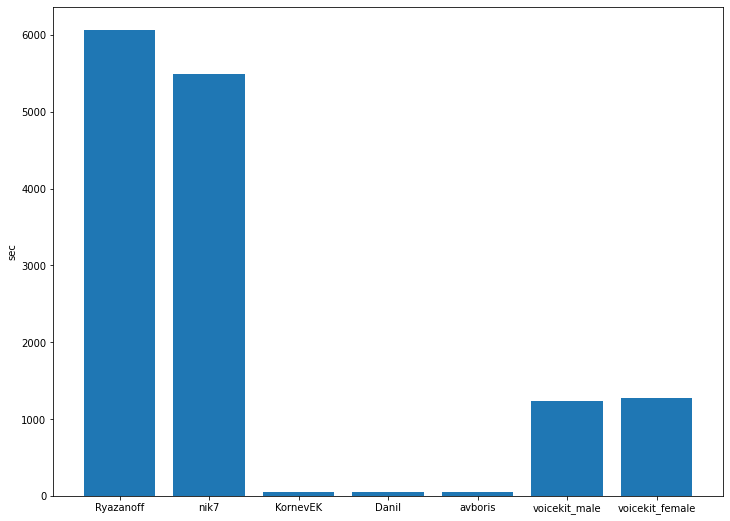

In [5]:
plt.figure(figsize=(12, 9))
plt.bar(*zip(*map(lambda x: (classes['name'][x], data[x].shape[0] / sr), data)))
plt.ylabel('sec');

In [6]:
%%time
non_silent_data = {}
for i in data:
    non_silent_data[i] = np.concatenate([data[i][j:k] for (j, k) in librosa.effects.split(data[i])])
del data

CPU times: user 1.72 s, sys: 2.84 s, total: 4.56 s
Wall time: 4.62 s


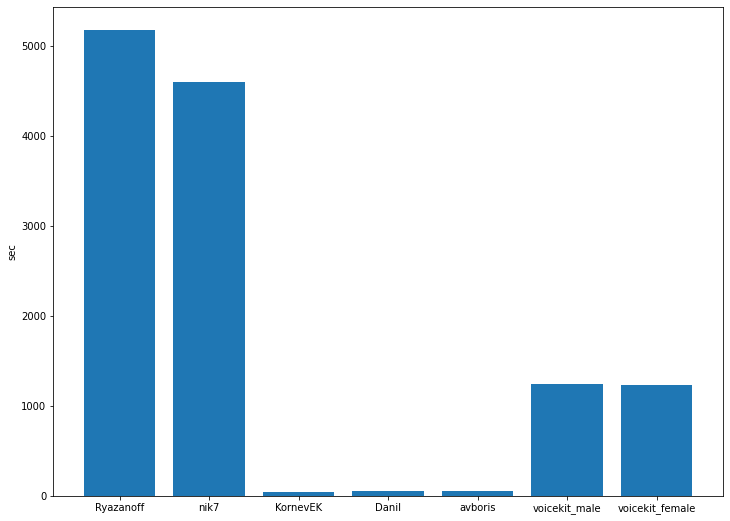

In [7]:
plt.figure(figsize=(12, 9))
plt.bar(*zip(*map(lambda x: (classes['name'][x], non_silent_data[x].shape[0] / sr), non_silent_data)))
plt.ylabel('sec');

In [8]:
from sklearn.model_selection import train_test_split

train_data = {}
val_data = {}

for i in non_silent_data:
    sample = non_silent_data[i]
    sample_parts = sample.shape[0] // sr // dt
    head, tail = sample[:sample_parts*sr*dt], sample[sample_parts*sr*dt:]
    train, val = train_test_split(head.reshape(-1, sr * dt), test_size=val_size, shuffle=True, random_state=random_state)
    train_data[i] = np.concatenate([train.reshape(-1), tail])
    val_data[i] = val.reshape(-1)
del non_silent_data

Balance dataset:

In [9]:
max_dataset_size = max(train_data[i].shape[0] // sr // dt for i in train_data) + 1

train_data_balanced = {}
for i in train_data:
    sample = train_data[i]
    sample_parts = sample.shape[0] // sr // dt
    train_data_balanced[i] = np.concatenate(
        [sample[:sample_parts*sr*dt].reshape(-1, sr*dt)] + \
        [sample[j:j+sr*dt].reshape(-1, sr*dt) for j in np.random.randint(0, sample.shape[0]-sr*dt, size=max_dataset_size-sample_parts)])
del train_data

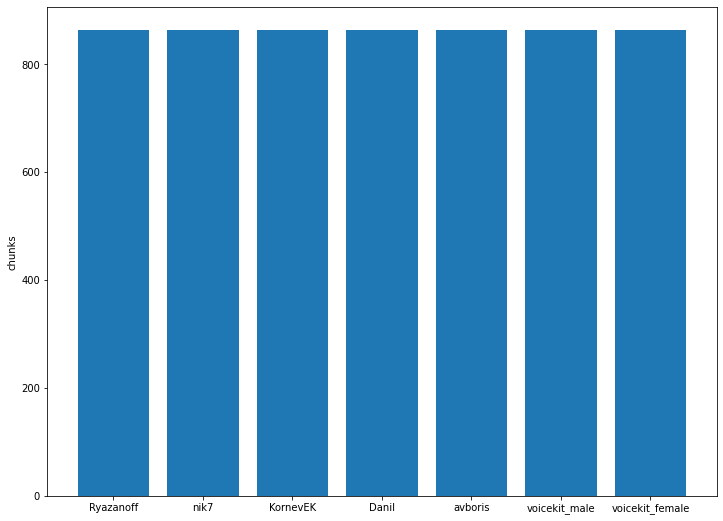

In [10]:
plt.figure(figsize=(12, 9))
plt.bar(*zip(*map(lambda x: (classes['name'][x], train_data_balanced[x].shape[0]), train_data_balanced)))
plt.ylabel('chunks');

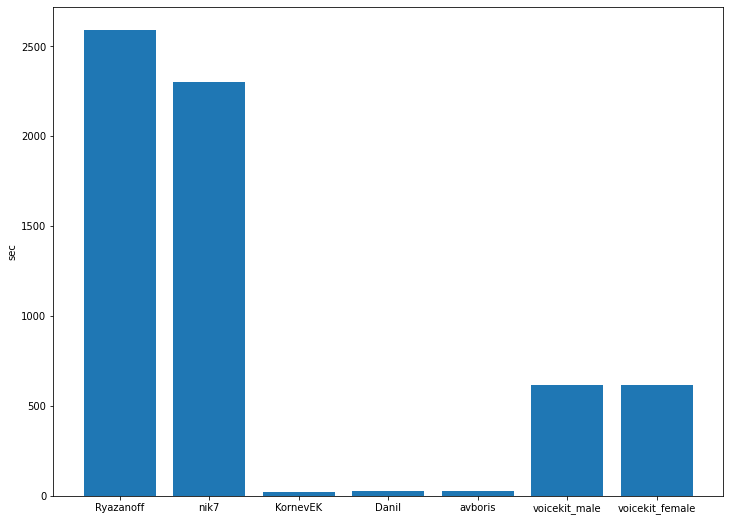

In [11]:
plt.figure(figsize=(12, 9))
plt.bar(*zip(*map(lambda x: (classes['name'][x], val_data[x].shape[0] / sr), val_data)))
plt.ylabel('sec');

In [12]:
X_train = []
y_train = []

for i in train_data_balanced:
    X_train.append(train_data_balanced[i])
    y_train += [i] * train_data_balanced[i].shape[0]
X_train = np.concatenate(X_train)
y_train = np.array(y_train)
del train_data_balanced

In [13]:
X_train.shape, y_train.shape

((6041, 66150), (6041,))

In [14]:
np.save('data/X_train.npy', X_train)
np.save('data/y_train.npy', y_train)

In [15]:
X_val = []
y_val = []

for i in val_data:
    val_data[i] = val_data[i].reshape(-1, sr*dt)
    X_val.append(val_data[i])
    y_val += [i] * val_data[i].shape[0]
X_val = np.concatenate(X_val)
y_val = np.array(y_val)
del val_data

In [16]:
X_val.shape, y_val.shape

((2068, 66150), (2068,))

In [17]:
np.save('data/X_val.npy', X_val)
np.save('data/y_val.npy', y_val)

In [18]:
X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')

In [19]:
X_val = np.load('data/X_val.npy')
y_val = np.load('data/y_val.npy')

## 1D CNN model

Based on model from [this article](https://benanne.github.io/2014/08/05/spotify-cnns.html) and code from [this](https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7).

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics

Using TensorFlow backend.


In [21]:
n_mfcc = 64
num_epochs = 128
batch_size = 16

In [22]:
def extract_features(sample):
    global sr, n_mfcc
    mfccs = librosa.feature.mfcc(y=sample, sr=sr, n_mfcc=n_mfcc)
#    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs

In [23]:
%%time
X_train_features = np.array(list(map(extract_features, X_train)))
X_val_features = np.array(list(map(extract_features, X_val)))

CPU times: user 3min 7s, sys: 1min 31s, total: 4min 38s
Wall time: 1min 9s


In [24]:
X_train_features.shape, X_val_features.shape

((6041, 64, 130), (2068, 64, 130))

In [25]:
X_train_features = X_train_features.transpose(0, 2, 1)
X_val_features = X_val_features.transpose(0, 2, 1)

In [26]:
X_train_features.shape, X_val_features.shape

((6041, 130, 64), (2068, 130, 64))

In [27]:
from keras.utils import to_categorical

Y_train = to_categorical(y_train)
Y_val = to_categorical(y_val)

In [28]:
t = X_train_features.shape[1]
c = X_train_features.shape[2]

X_train_features = X_train_features.reshape(X_train_features.shape[0], t, c)
X_val_features = X_val_features.reshape(X_val_features.shape[0], t, c)

In [29]:
X_train_features.shape, X_val_features.shape

((6041, 130, 64), (2068, 130, 64))

In [30]:
num_labels = Y_train.shape[1]

In [31]:
model = Sequential()
model.add(Conv1D(filters=2*c, kernel_size=4, input_shape=(t, c), activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=2*c, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=4*c, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling1D())
model.add(Dense(4*c, activation='relu'))
model.add(Dense(2*c, activation='relu'))
model.add(Dense(num_labels, activation='softmax'))

In [32]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 127, 128)          32896     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 63, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 128)           65664     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 30, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 29, 256)          

In [33]:
score = model.evaluate(X_val_features, Y_val, verbose=1)

print(f'accuracy={100 * score[1]}%, loss={score[0]}') 

2068/2068 [==============================] - 0s 216us/step
accuracy=37.08897531032562%, loss=5.180509980501358


In [34]:
%%time

from keras.callbacks import ModelCheckpoint 
from datetime import datetime

checkpointer = ModelCheckpoint(filepath='weights.best.cnn1d.hdf5', verbose=1, save_best_only=True)

history = model.fit(
    X_train_features,
    Y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_val_features, Y_val),
    callbacks=[checkpointer],
    verbose=10
)

Train on 6041 samples, validate on 2068 samples
Epoch 1/128

Epoch 00001: val_loss improved from inf to 0.03657, saving model to weights.best.cnn1d.hdf5
Epoch 2/128

Epoch 00002: val_loss improved from 0.03657 to 0.02590, saving model to weights.best.cnn1d.hdf5
Epoch 3/128

Epoch 00003: val_loss improved from 0.02590 to 0.02002, saving model to weights.best.cnn1d.hdf5
Epoch 4/128

Epoch 00004: val_loss did not improve from 0.02002
Epoch 5/128

Epoch 00005: val_loss did not improve from 0.02002
Epoch 6/128

Epoch 00006: val_loss did not improve from 0.02002
Epoch 7/128

Epoch 00007: val_loss improved from 0.02002 to 0.01412, saving model to weights.best.cnn1d.hdf5
Epoch 8/128

Epoch 00008: val_loss did not improve from 0.01412
Epoch 9/128

Epoch 00009: val_loss did not improve from 0.01412
Epoch 10/128

Epoch 00010: val_loss did not improve from 0.01412
Epoch 11/128

Epoch 00011: val_loss improved from 0.01412 to 0.01354, saving model to weights.best.cnn1d.hdf5
Epoch 12/128

Epoch 00012


Epoch 00120: val_loss did not improve from 0.00842
Epoch 121/128

Epoch 00121: val_loss did not improve from 0.00842
Epoch 122/128

Epoch 00122: val_loss did not improve from 0.00842
Epoch 123/128

Epoch 00123: val_loss did not improve from 0.00842
Epoch 124/128

Epoch 00124: val_loss did not improve from 0.00842
Epoch 125/128

Epoch 00125: val_loss did not improve from 0.00842
Epoch 126/128

Epoch 00126: val_loss did not improve from 0.00842
Epoch 127/128

Epoch 00127: val_loss did not improve from 0.00842
Epoch 128/128

Epoch 00128: val_loss did not improve from 0.00842
CPU times: user 50min 11s, sys: 1min 51s, total: 52min 3s
Wall time: 11min 29s


In [35]:
score = model.evaluate(X_val_features, Y_val, verbose=1)

print(f'accuracy={100 * score[1]}%, loss={score[0]}') 

2068/2068 [==============================] - 0s 210us/step
accuracy=99.80657696723938%, loss=0.05853163420504253


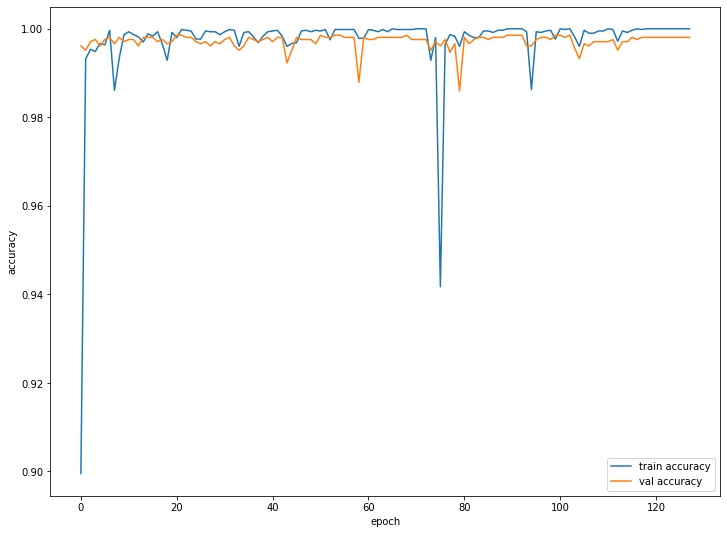

In [36]:
plt.figure(figsize=(12, 9))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

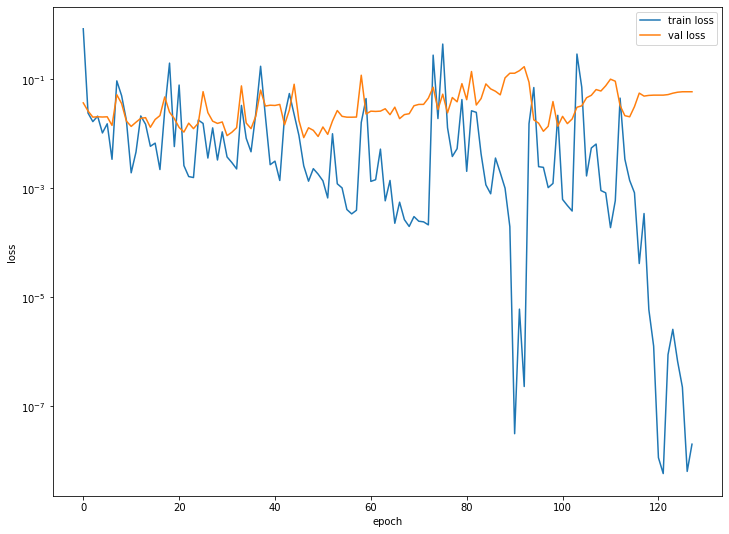

In [37]:
plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.legend();

Dropout layers prevent of overfitting. More training data could eliminate it completely.

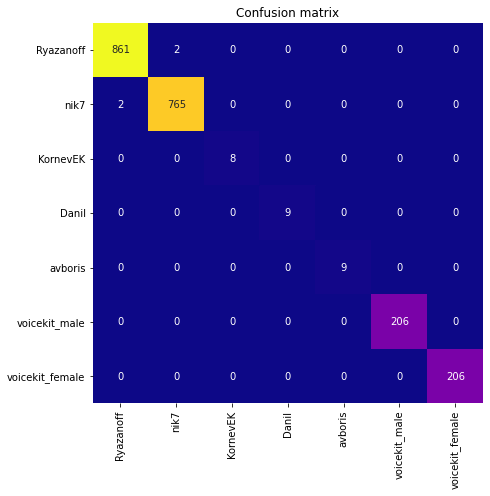

In [38]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(7, 7))
sns.heatmap(
    confusion_matrix(y_val, model.predict_classes(X_val_features)),
    annot=True,
    fmt='g',
    cbar=False,
    xticklabels=classes['name'],
    yticklabels=classes['name'],
    cmap='plasma'
)
plt.title('Confusion matrix');

In [39]:
preds = model.predict_classes(X_val_features)
misunderstood_data = X_val[preds != y_val]
IPython.display.Audio(np.asfortranarray(misunderstood_data.reshape(-1)), rate=sr)

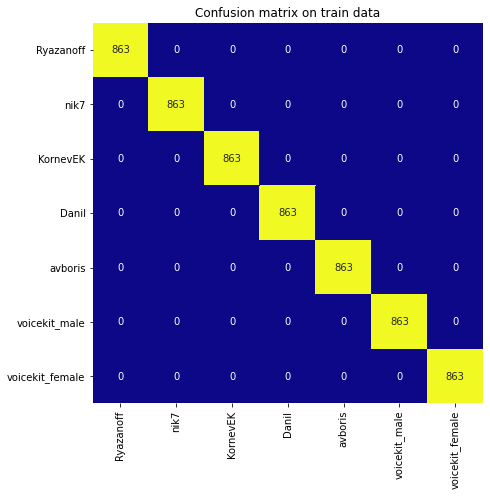

In [40]:
plt.figure(figsize=(7, 7))
sns.heatmap(
    confusion_matrix(y_train, model.predict_classes(X_train_features)),
    annot=True,
    fmt='g',
    cbar=False,
    xticklabels=classes['name'],
    yticklabels=classes['name'],
    cmap='plasma'
)
plt.title('Confusion matrix on train data');

In [ ]:
preds = model.predict_classes(X_train_features)
misunderstood_data = X_train[preds != y_train]
IPython.display.Audio(np.asfortranarray(misunderstood_data.reshape(-1)), rate=sr)

Errors occure only on "garbage" data from additional dataset. Initial dataset is correctly classified.